In [310]:
#load the important libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi

In [311]:
#set the default parameters
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']=14
plt.rcParams['image.cmap']='plasma'
plt.rcParams['axes.linewidth']=2

In [312]:
from cycler import cycler
cols= plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle']=cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [313]:
# The time toy series for our example is f_{t}=0.001 x (t - 100)(care) + 2sin(2pit/p1) + 0.75sin(2pit/p2) + rand{-1+1}

N=200
t= np.arange(0, N)
trend = 0.001*pow((t - 100), 2)
p1 = 20
p2 = 30
f1=2*np.sin(2*pi*t/p1)
f2=0.75*np.sin(2*pi*t/p2)
np.random.seed(123) # So we generate the same noisy time series every time.
noise= 2*np.random.rand(N) - 0.5

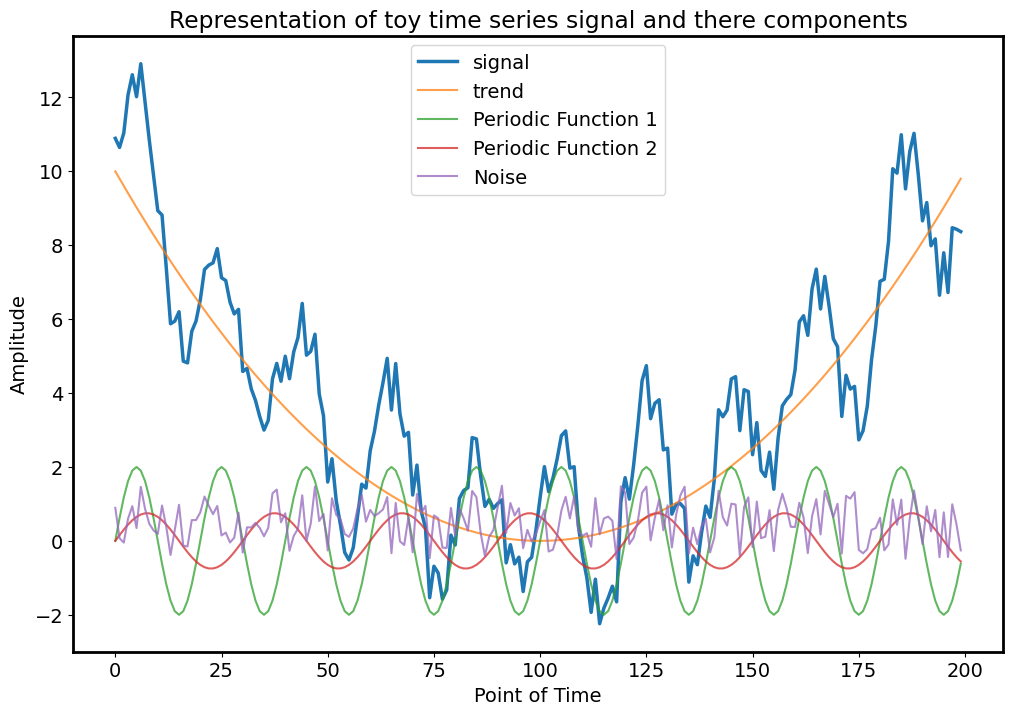

In [314]:
#plot the function
signal= trend + f1 + f2 + noise

plt.plot(t, signal, lw=2.5, label='The toy time seies')
plt.plot(t, trend, alpha=0.75, label='trend')
plt.plot(t, f1, alpha=0.75, label='periode function 1')
plt.plot(t, f2, alpha=0.75, label='periode function 2')
plt.plot(t, noise, alpha=0.75, label='Noise')
plt.legend(['signal', 'trend', 'Periodic Function 1', 'Periodic Function 2', 'Noise'])
plt.xlabel('Point of Time')
plt.ylabel('Amplitude')
plt.title('Representation of toy time series signal and there components')
plt.show()

In [315]:
#now let's build out matrix from this time series and call it the trajectory matrix

L = int(N/2)
print(L)
K = int(N - L + 1)
print(K)
X = np.column_stack([signal[i:i+L] for i in range(K)])

100
101


In [316]:
# I understand it like this 
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n=len(a)
print(n)
l=int(n/2)
print(l)
k=int(n-l+1)
print(k)

x=np.column_stack([a[i:i+l] for i in range(0,k)])
print(x)

10
5
6
[[0 1 2 3 4 5]
 [1 2 3 4 5 6]
 [2 3 4 5 6 7]
 [3 4 5 6 7 8]
 [4 5 6 7 8 9]]


Text(0.5, 1.0, 'Trajctory Matrix')

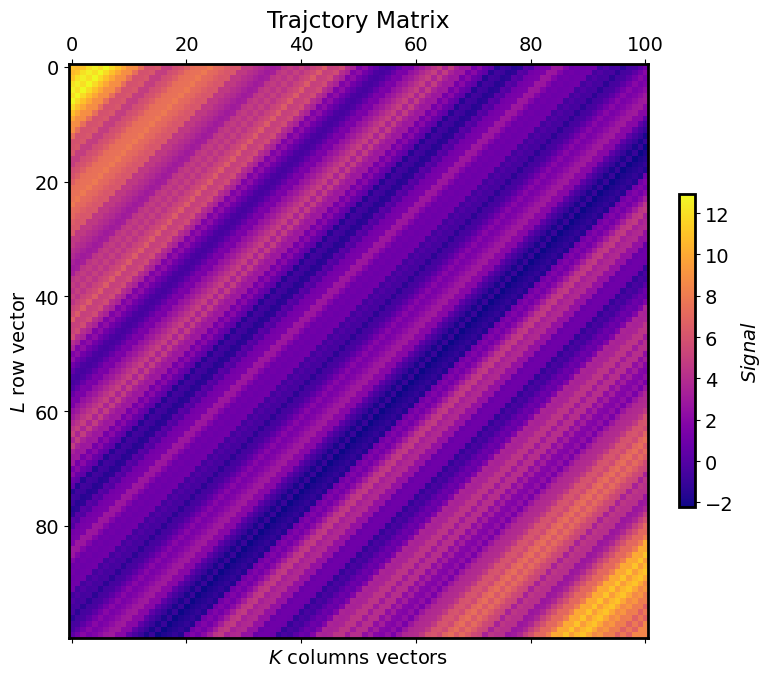

In [317]:
ax = plt.matshow(X)
plt.xlabel('$K$ columns vectors')
plt.ylabel('$L$ row vector')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label('$Signal$')
plt.title('Trajctory Matrix')

In [318]:
#First we need the rank of the Trajectory matrix
d= np.linalg.matrix_rank(X)

#second we will calculate the SVD i=of our trajctory matrix
U, Sigma, V = np.linalg.svd(X)

#Tranpose of V
V= V.T

#now let's calculate the X element wich is the sum from 0 to the rank of Ui*Sigmai *VTi
X_element= (Sigma[i]*np.outer(U[:, i], V[:, i]) for i in range(0, d))
# we should check if the total of X_element equal to X
X_element = np.array(list(X_element), dtype=float)

if not np.allclose(X, X_element.sum(axis=0), atol=0.00000000000001):
    print("re-check the calculation")

In [319]:
log_S = np.log(Sigma)
"""
# Plot the logarithm of singular values
plt.plot(log_S)
plt.xlabel('Index of Singular Value')
plt.ylabel('Logarithm of Singular Value')
plt.title('Singular Value Analysis')
plt.show()
"""

"\n# Plot the logarithm of singular values\nplt.plot(log_S)\nplt.xlabel('Index of Singular Value')\nplt.ylabel('Logarithm of Singular Value')\nplt.title('Singular Value Analysis')\nplt.show()\n"

"\nplt.xlabel('Sample Index')\nplt.ylabel('Amplitude')\nplt.title('Eigenvectors as Points from Singular Value Decomposition')\nplt.legend()\nplt.show()\n"

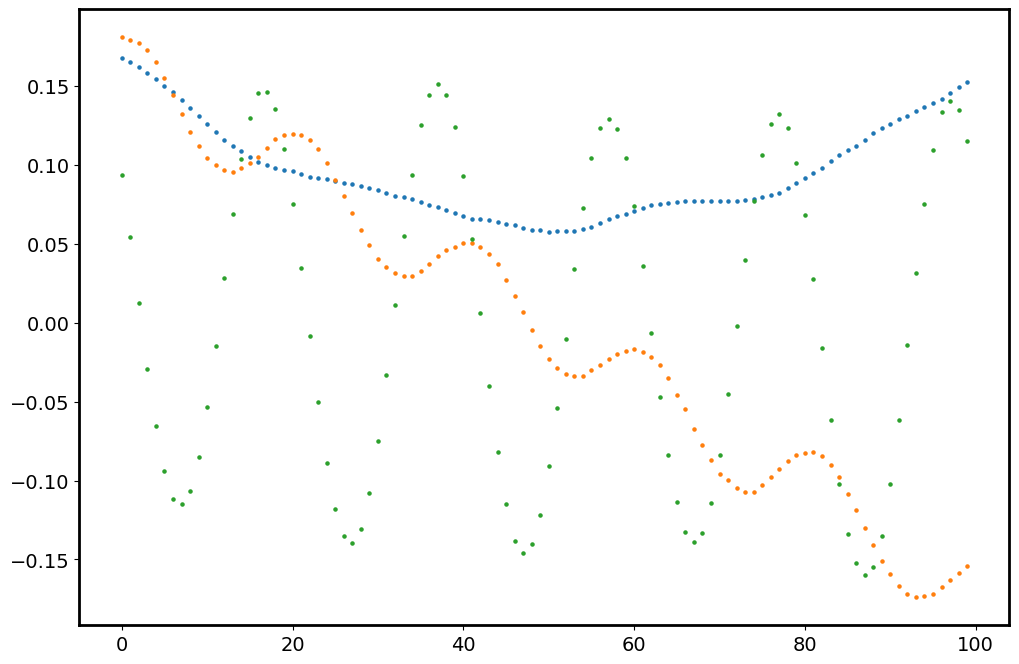

In [320]:
# Create a scatter plot for each eigenvector
num_eigenvectors_to_plot = min(3, U.shape[1])  # Plot at most the first 3 eigenvectors

for i in range(num_eigenvectors_to_plot):
    plt.scatter(range(len(U[:, i])), U[:, i], label=f'Eigenvector {i + 1}', s=5)
"""
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Eigenvectors as Points from Singular Value Decomposition')
plt.legend()
plt.show()
"""

In [321]:
"""
# Number of eigentriples to consider
num_eigentriples = min(12, U.shape[1])

# Compute eigentriples
eigentriples = [(Sigma[i], U[:, i], 2 * np.pi / Sigma[i]) for i in range(num_eigentriples)]

# Display the numerical values
for i, (eigenvalue, eigenvector, period) in enumerate(eigentriples):
    print(f'Eigentriple {i + 1}:')
    print(f'  Eigenvalue: {eigenvalue:.4f}')
    print(f'  Period: {period:.4f}')
    #print(f'  Eigenvector:')
    #print(eigenvector)
    print('\n' + '-'*40 + '\n')
"""

"\n# Number of eigentriples to consider\nnum_eigentriples = min(12, U.shape[1])\n\n# Compute eigentriples\neigentriples = [(Sigma[i], U[:, i], 2 * np.pi / Sigma[i]) for i in range(num_eigentriples)]\n\n# Display the numerical values\nfor i, (eigenvalue, eigenvector, period) in enumerate(eigentriples):\n    print(f'Eigentriple {i + 1}:')\n    print(f'  Eigenvalue: {eigenvalue:.4f}')\n    print(f'  Period: {period:.4f}')\n    #print(f'  Eigenvector:')\n    #print(eigenvector)\n    print('\n' + '-'*40 + '\n')\n"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

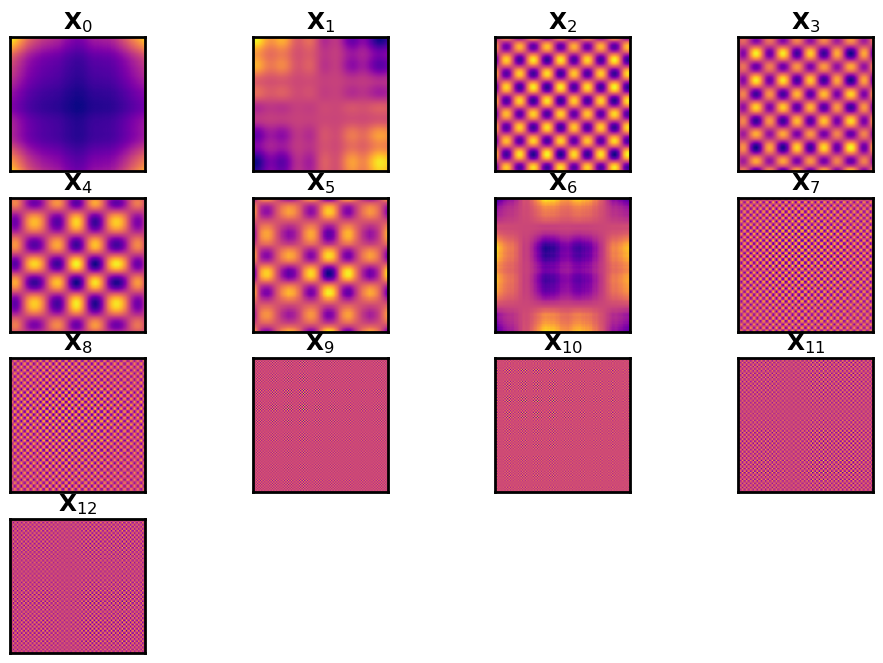

In [322]:
#let's plot the different element Svd of X trajectory matrix
n= min(12, d) #Randomly we will choose only 12 first elemnt and n is a check if d less than 12

for i in range(n+1):
 plt.subplot(4,4,i+1)
 titel= "$\mathbf{X}_{" + str(i) + "}$"
 plot_2d(X_element[i], titel)
plt.tight_layout

Text(0, 0.5, 'The Percentage %')

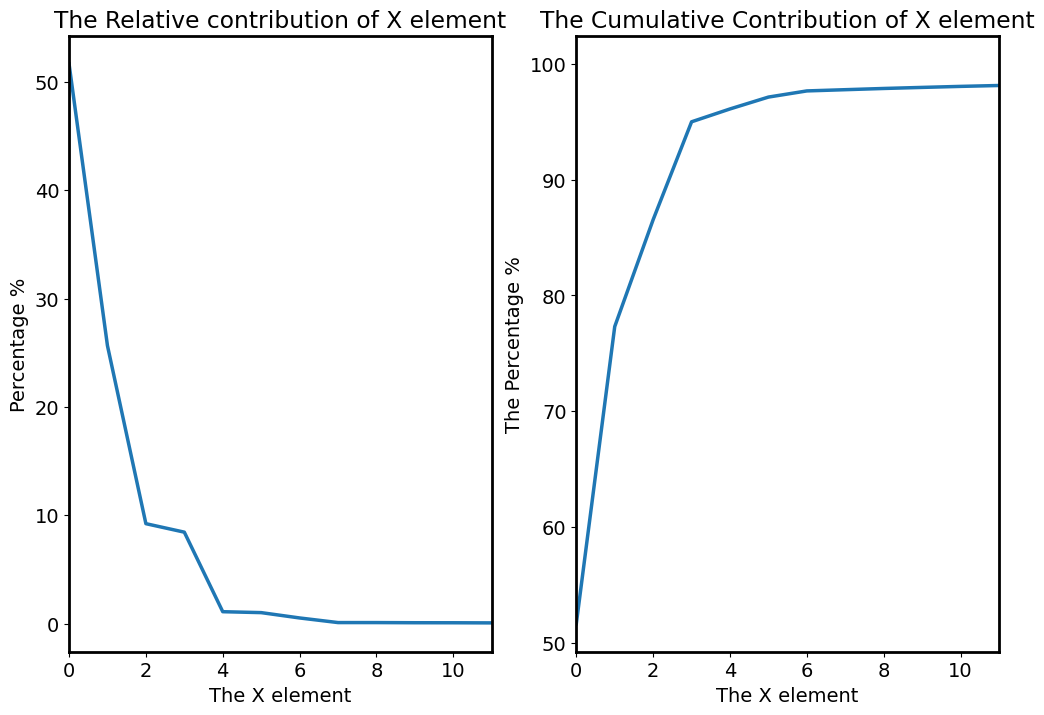

In [323]:
#Let's plot the relative contributions,  σ2i∑d−1k=0σ2k
#the cumulative contributions,  ∑ij=0σ2j∑d−1k=0σ2k

Relative_Con= pow(Sigma, 2).sum()
Cumulative_Con= pow(Sigma, 2).cumsum()
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Sigma**2 / Relative_Con *100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title('The Relative contribution of X element')
ax[0].set_xlabel('The X element')
ax[0].set_ylabel('Percentage %')
ax[1].plot(Cumulative_Con/Relative_Con*100, lw= 2.5)
ax[1].set_xlim(0,11)
ax[1].set_title('The Cumulative Contribution of X element')
ax[1].set_xlabel('The X element')
ax[1].set_ylabel('The Percentage %')


In [324]:
#Now let's move on to the reconstruction of the time series
#The worls is not perfect so we should transform the X element into a hankl matrix 
#So we will made a function of the Hankle Operator

def HankleOp(X):
    
    L, K = X.shape
    transpose = False
    
    #Hankle Operator works only if L < K 
    if L > K:
        X = X.T
        L, K = K, L
        transpose = True

    #First we should intilize ou new Matrix Hankle Matrix 
    HX = np.zeros((L, K))
    
    #Now let's fill it
    
    for m in range(L):
        for n in range(K):
            s = m + n 
            # Row 
            if  0 <= s <= L - 1:
                for i in range(0, s+1):
                    HX[m,n] += 1/(s+1)*X[i,s-i]
            #Column
            elif L <= s <= K -1:
                for i in range(0,L-1):   
                    HX[m,n] += 1/(L-1)*X[i,s-i]
            
            elif K <= s <= K + L - 2:
                a= s - K + 1
                for i in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[i,s-i]
    if transpose:
        return HX.T
    else: return HX

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

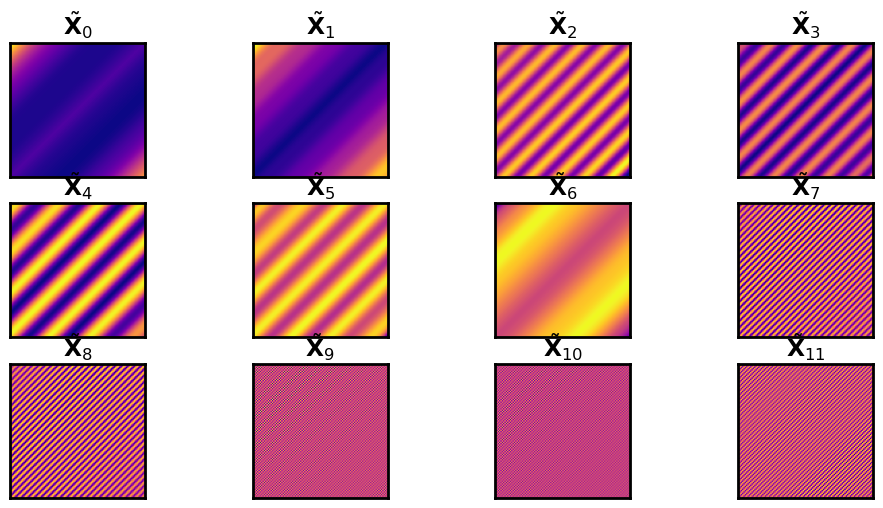

In [325]:
n = min(12, d)
for i in range(n):
    plt.subplot(4, 4, i+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(i) + "}$"
    plot_2d(HankleOp(X_element[i]), title)
plt.tight_layout

In [326]:
def shortcut(X_i):
    X_reverse = X_i[::-1] 
    diags = [X_reverse.diagonal(i).mean() for i in range(-X_i.shape[0]+1,X_i.shape[1])]
    return diags

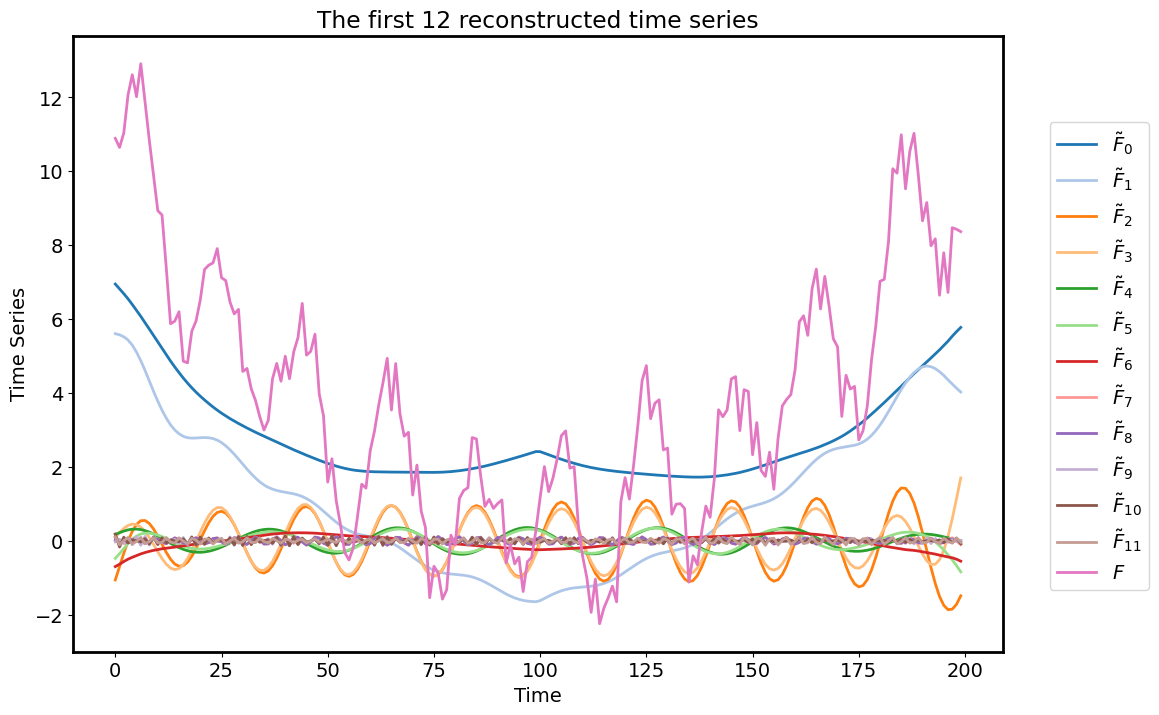

In [327]:
n = 12

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    time_series= shortcut(X_element[i])
    fig.axes.plot(t, time_series, lw=2)
    
fig.axes.plot(t, signal, lw=2)
fig.set_xlabel('Time')
fig.set_ylabel('Time Series')
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title('The first 12 reconstructed time series')
fig.legend(legend, loc=(1.05,0.1));

In [332]:
# how we could merge the sub_component with each other 
#we should build a method to see if a two or more X_element should be merged together
#if we can see how much element in each reconstructed time serie F_i and F_j and represented as a factor w_k=(F_i,F_j)= {K +1 if 0<=k<=L-1} {L if L<=k<=K-1} {N-K if K<=k<=N-1}
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1)  + list(np.arange(L)+1)[::-1])

#store all the element as a toy time serie
Signal_i= np.array([shortcut(X_element[i]) for i in range(d)])

#now let's calculate the norm of the matrice
Norm_signal = np.array([w.dot(Signal_i[i]**2) for i in range(d)])
Norm_signal= Norm_signal**-0.5

#let's calculate the correlation matrice
W_corr= np.identity(d)
for i in range(d):
    for j in range(i+1, d):
        W_corr[i,j]= abs(w.dot(Signal_i[i]*Signal_i[j]) * (Norm_signal[i]*Norm_signal[j]))
        W_corr[j,i]=W_corr[i,j]


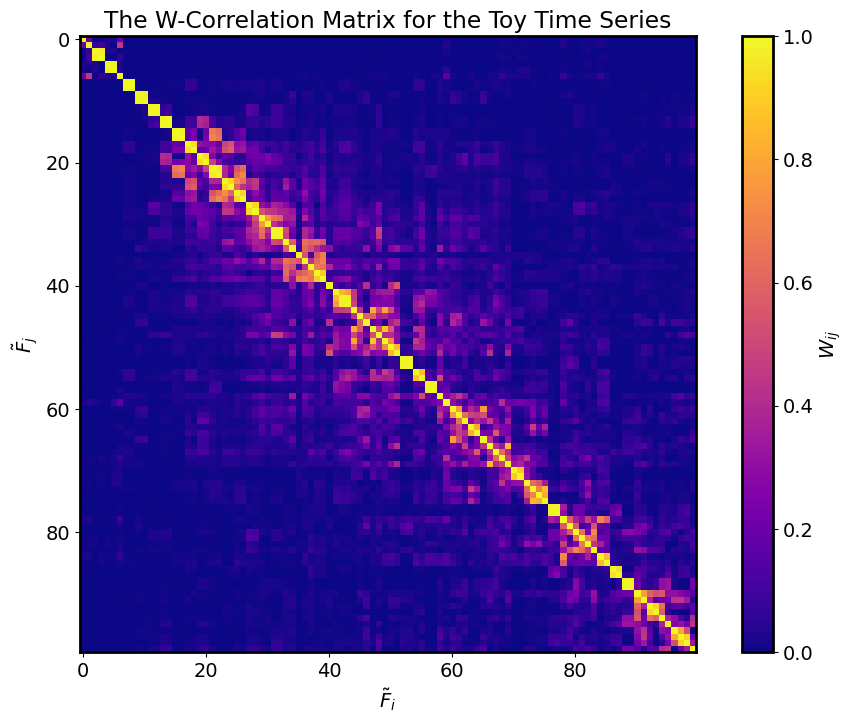

In [333]:
ax = plt.imshow(W_corr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series");

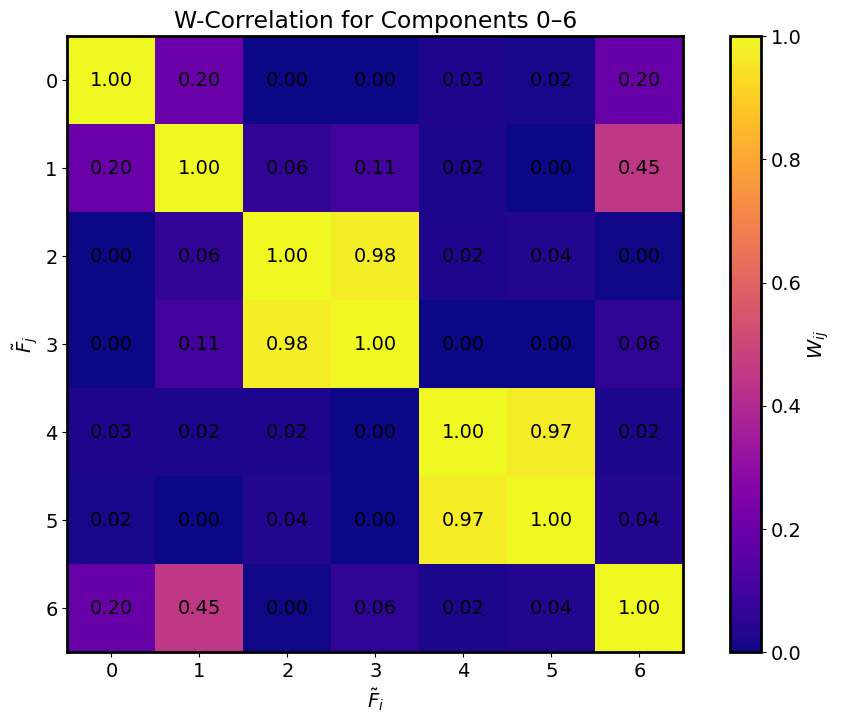

In [340]:
# Your existing code to create the plot
ax = plt.imshow(W_corr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5, 6.5)
plt.ylim(6.5, -0.5)
plt.clim(0, 1)
plt.title(r"W-Correlation for Components 0–6")

# Add annotations for each value in Wcorr
for i in range(W_corr.shape[0]-93):
    for j in range(W_corr.shape[1]-93):
        plt.text(j, i, f'{W_corr[i, j]:.2f}', ha='center', va='center', color='black')

# Show the plot
plt.show()

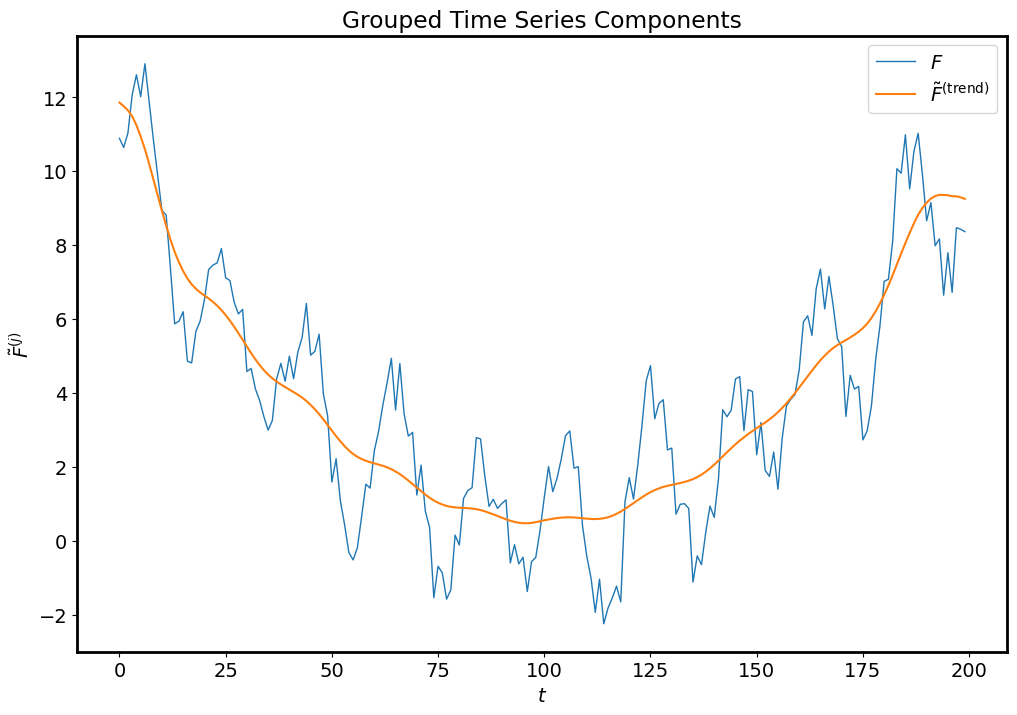

In [343]:
# Assemble the grouped components of the time series.
F_trend = shortcut(X_element[[0,1,6]].sum(axis=0))
#F_periodic1 = shortcut(X_element[[2,3]].sum(axis=0))
#F_periodic2 = shortcut(X_element[[4,5]].sum(axis=0))
#F_noise = shortcut(X_element[7:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,signal, lw=1)
plt.plot(t, F_trend)
#plt.plot(t, F_periodic1)
#plt.plot(t, F_periodic2)
#plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()